# MCPRO > Analyse et modélisation d'une réponse indicielle (debriefing)

## Obtention de la réponse indicielle expérimentale

### Fichier de mesures complet

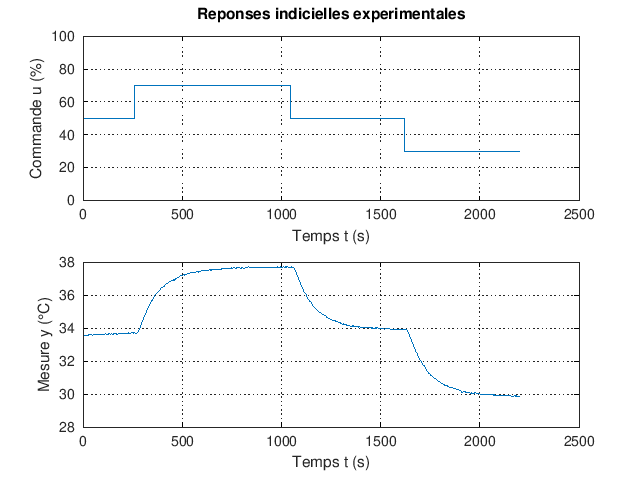

In [34]:
%plot inline -s 640,480 -f png
%------------------------------------------------------------------------------------------
% Obtention de la réponse indicielle expérimentale
% Charger et visualiser les signaux de mesures
%------------------------------------------------------------------------------------------
% Vous POUVEZ modifier les valeurs des variables filename (nom du fichier de mesures) et 
% yunit (unité des mesures) dans cette cellule si nécessaire, puis l'exécuter (run)
%------------------------------------------------------------------------------------------

filename = './data/reponsesindicielles.txt'; % À changer si votre fichier de mesures à un nom différent
yunit = '\degC'; % Par exemple : '\degC', 'mbar', 'cm', etc.

%------------------------------------------------------------------------------------------
% Dans un premier temps, ne modifiez PAS ce qui suit et exécutez la cellule de code telle 
% quelle. Ensuite, vous pouvez apporter des modifications si vous le jugez utile.
%------------------------------------------------------------------------------------------

% Taille des caractères pour les graphiques
set (0, "defaultaxesfontsize", 14);

% Chargement du fichier de mesures (changez son nom si nécessaire)
data = load(filename);

% Extraction des variables temps, entrée et sortie
t = data(:,1);
u = data(:,3);
y = data(:,6);

% Tracé des courbes
subplot(2,1,1); stairs(t,u); grid on;
title('Reponses indicielles experimentales')
ylabel('Commande u (%)')
xlabel('Temps t (s)')
ylim([0 100]);
set(gca, 'fontsize', 14, 'gridlinestyle', ':');
subplot(2,1,2); plot(t,y); grid on;
ylabel(sprintf('Mesure y (%s)',yunit))
xlabel('Temps t (s)')
set(gca, 'fontsize', 14, 'gridlinestyle', ':');

### Réponse indicielle isolée

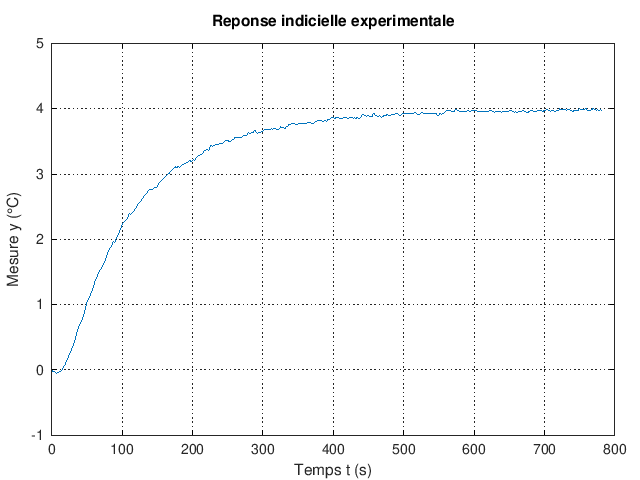

In [35]:
%------------------------------------------------------------------------------------------
% Obtention de la réponse indicielle expérimentale
% Isoler une seule réponse indicielle du fichier de mesure
%------------------------------------------------------------------------------------------
% Vous DEVEZ modifier les valeurs des variables debut et fin (numéros de lignes) dans cette
% cellule, puis l'exécuter (run)
%------------------------------------------------------------------------------------------

debut = 260; % Numéro de la ligne de début de la réponse indicielle sélectionnée
fin = 1042; % Numéro de la ligne de fin de la réponse indicielle sélectionnée

%------------------------------------------------------------------------------------------
% Dans un premier temps, ne modifiez PAS ce qui suit et exécutez la cellule de code telle 
% quelle. Ensuite, vous pouvez apporter des modifications si vous le jugez utile.
%------------------------------------------------------------------------------------------

% Extraction des variables temps, entrée et sortie
t = data(debut:fin,1) - data(debut,1);
u = data(debut:fin,3) - data(debut,3);
y = data(debut:fin,6) - data(debut,6);

% Tracé des courbes
plot(t,y); grid on;
title('Reponse indicielle experimentale')
ylabel(sprintf('Mesure y (%s)',yunit))
xlabel('Temps t (s)')
set(gca, 'fontsize', 14, 'gridlinestyle', ':');
% ylims = get(gca,'ylim'); ylims = [ylims(1)-diff(ylims)/20 ylims(2)+diff(ylims)/20]; ylim(ylims);

% Enregistrement d'une image du graphique
print -dpng reponse_experimentale.png

## Analyse et modélisation de la réponse indicielle expérimentale

R2 =  0.99913
EQM =  0.0015156


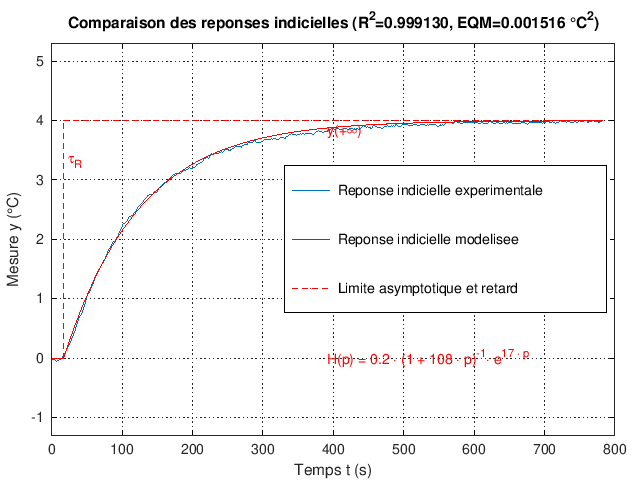

In [36]:
%------------------------------------------------------------------------------------------
% Analyse et modélisation de la réponse indicielle expérimentale
%------------------------------------------------------------------------------------------
% Vous DEVEZ modifier les valeurs des variables Du (amplitude de variation de la commande), 
% K (gain statique) et taur (retard) dans cette cellule, puis l'exécuter (run)
%------------------------------------------------------------------------------------------

Du = 20;
K = 0.2; % Valeur du gain statique, dans l'unité cohérente avec celles de y et u
taur = 17; % Valeur du retard en secondes

%------------------------------------------------------------------------------------------
% Vous DEVEZ modifier les valeurs des variables n (ordre), et tau (constante de temps) ou
% omega0 (pulsation naturelle) dans cette cellule, puis l'exécuter (run)
%------------------------------------------------------------------------------------------

n = 1; % indiquez 1 si vous pensez que le système est d'ordre un, et 2 si vous pensez qu'il est d'ordre supérieur à un 
tau = 108; % Pour n=1, valeur de la constante de temps en secondes
omega0 = 1; % Pour n=2, valeur de la pulsation naturelle en hertz

%------------------------------------------------------------------------------------------
% Dans un premier temps, ne modifiez PAS ce qui suit et exécutez la cellule de code telle 
% quelle. Ensuite, vous pouvez apporter des modifications si vous le jugez utile.
%------------------------------------------------------------------------------------------

% Calcul de la valeur asymptotique de y
yinf = y(1) + K*Du;

% Calcul de la réponse indicielle du modèle en fonction de son ordre
if n==1 % Ordre un
    H = tf(K,[tau 1]);
    textmod = sprintf('H(p) = %g \\cdot (1 + %g \\cdot p)^{-1}', K, tau); % Équation à afficher
else % Ordre deux ou plus
    H = tf(K,[1/omega0^2 2/omega0 1]);
    textmod = sprintf('H(p) = %g \\cdot (1 + p / %g)^{-2}', K, omega0);  % Équation à afficher
end
ymod(find(t<taur)) = y(1); % Prise en compte du retard
if taur>0
    textmod = strcat(textmod, sprintf('\\cdot e^{%g \\cdot p}', taur));  % Équation à afficher
end
u = ones(size(y))*Du;
ymod = lsim(H,u,t);

% Prise en compte du retard
m = length(find(t<taur));
ymod = [ones(m,1)*y(1); ymod(1:end-m)];

% Calcul du score
R2 = (var(y) - var(ymod-y)) / var(y)
EQM = mean((ymod-y).^2)

% Tracé des courbes
plot(t,y, t,ymod, 'r-', [taur t(end)], [yinf yinf], 'r--', [taur taur], [y(1) yinf], 'r--'); grid on;
title(sprintf('Comparaison des reponses indicielles (R^2=%f, EQM=%f %s^2)', R2, EQM, yunit))
ylabel(sprintf('Mesure y (%s)',yunit))
xlabel('Temps t (s)')
legend('Reponse indicielle experimentale','Reponse indicielle modelisee', 'Limite asymptotique et retard', 'location', 'east');
set(gca, 'gridlinestyle', ':');
ylims = get(gca,'ylim'); ylims = [ylims(1)-diff(ylims)/20 ylims(2)+diff(ylims)/20]; ylim(ylims);

% Ajout des étiquettes sur le graphique
h = text(mean(t),yinf,'y(+\infty)','fontsize', 14, 'color', [1 0 0]);
p = get(h,'position'); e = get(h,'extent');
set(h, 'position', [p(1) p(2)-e(4)/2 p(3)]);
if taur>0
    text(taur,mean(y),' \tau_R','fontsize', 14, 'color', [1 0 0]);
end
text(mean(t),y(1),textmod, 'fontsize', 14, 'color', [1 0 0]);

% Enregistrement d'une image du graphique
print -dpng reponse_modelisee.png

## Modélisation **des** réponses indicielles expérimentales

R2 =  0.99872
EQM =  0.060640


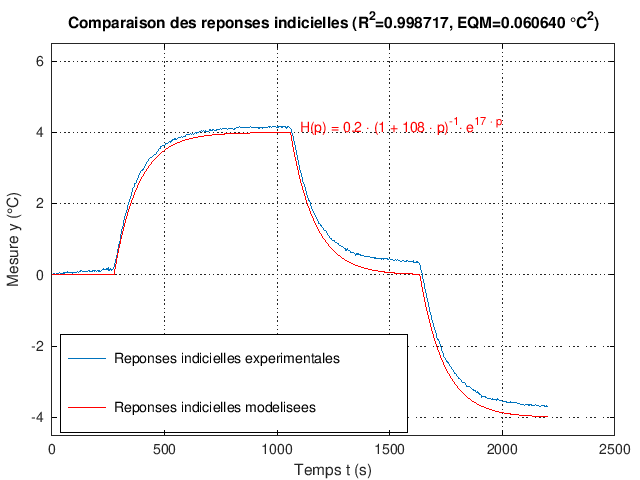

In [37]:
filename = './data/reponsesindicielles.txt'; % À changer si votre fichier de mesures à un nom différent
yunit = '\degC'; % Par exemple : '\degC', 'mbar', 'cm', etc.

% Chargement du fichier de mesures 
data = load(filename);

% Extraction des variables temps, entrée et sortie
t = data(:,1);
u = data(:,3) - data(1,3);
y = data(:,6) - data(1,6);

% Calcul de la réponse indicielle du modèle en fonction de son ordre
if n==1 % Ordre un
    H = tf(K,[tau 1]);
    textmod = sprintf('H(p) = %g \\cdot (1 + %g \\cdot p)^{-1}', K, tau); % Équation à afficher
else % Ordre deux ou plus
    H = tf(K,[1/omega0^2 2/omega0 1]);
    textmod = sprintf('H(p) = %g \\cdot (1 + p / %g)^{-2}', K, omega0);  % Équation à afficher
end
ymod(find(t<taur)) = y(1); % Prise en compte du retard
if taur>0
    textmod = strcat(textmod, sprintf('\\cdot e^{%g \\cdot p}', taur));  % Équation à afficher
end
ymod = lsim(H,u,t);

 % Prise en compte du retard
m = length(find(t<taur));
ymod = [ones(m,1)*y(1); ymod(1:end-m)];

% Calcul du score
R2 = (var(y) - var(ymod-y)) / var(y)
EQM = mean((ymod-y).^2)

% Tracé des courbes
plot(t,y, t,ymod, 'r-'); grid on;
title(sprintf('Comparaison des reponses indicielles (R^2=%f, EQM=%f %s^2)', R2, EQM, yunit))
ylabel(sprintf('Mesure y (%s)',yunit))
xlabel('Temps t (s)')
legend('Reponses indicielles experimentales','Reponses indicielles modelisees', 'location', 'southwest');
set(gca, 'gridlinestyle', ':');
ylims = get(gca,'ylim'); ylims = [ylims(1)-diff(ylims)/20 ylims(2)+diff(ylims)/20]; ylim(ylims);

% Ajout des étiquettes sur le graphique
text(mean(t),max(y),textmod, 'fontsize', 14, 'color', [1 0 0]);

## Conclusion n°1
> Le modèle du procédé $H(p)$, dont les paramètres ont été déterminés à partir d'une réponse indicielle expérimentale, permet de représenter assez bien d'autres réponses indicielles (obtenues avec des échelons différents, par exemple).

## Obtention de la réponse au pseudo bruit blanc (SBPA)

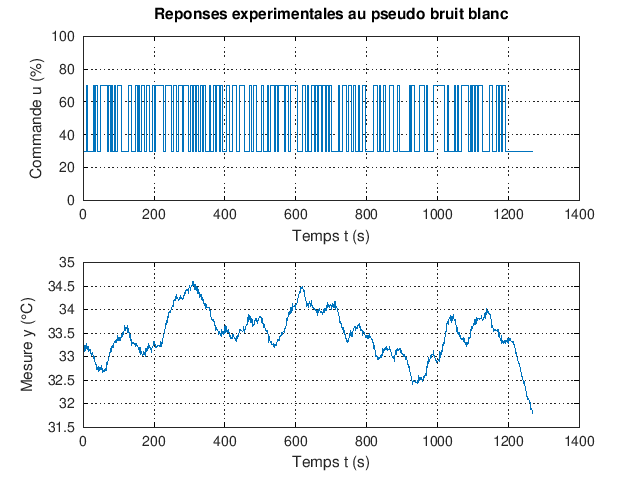

In [44]:
%plot inline -s 640,480 -f png
%------------------------------------------------------------------------------------------
% Obtention de la réponse indicielle expérimentale
% Charger et visualiser les signaux de mesures
%------------------------------------------------------------------------------------------
% Vous POUVEZ modifier les valeurs des variables filename (nom du fichier de mesures) et 
% yunit (unité des mesures) dans cette cellule si nécessaire, puis l'exécuter (run)
%------------------------------------------------------------------------------------------

filename = './data/pseudobruitblanc.txt'; % À changer si votre fichier de mesures à un nom différent
yunit = '\degC'; % Par exemple : '\degC', 'mbar', 'cm', etc.

%------------------------------------------------------------------------------------------
% Dans un premier temps, ne modifiez PAS ce qui suit et exécutez la cellule de code telle 
% quelle. Ensuite, vous pouvez apporter des modifications si vous le jugez utile.
%------------------------------------------------------------------------------------------

% Taille des caractères pour les graphiques
set (0, "defaultaxesfontsize", 14);

% Chargement du fichier de mesures (changez son nom si nécessaire)
data = load(filename);

% Extraction des variables temps, entrée et sortie
t = data(:,1);
u = data(:,3);
y = data(:,6);

% Tracé des courbes
subplot(2,1,1); stairs(t,u); grid on;
title('Reponses experimentales au pseudo bruit blanc')
ylabel('Commande u (%)')
xlabel('Temps t (s)')
ylim([0 100]);
set(gca, 'fontsize', 14, 'gridlinestyle', ':');
subplot(2,1,2); plot(t,y); grid on;
ylabel(sprintf('Mesure y (%s)',yunit))
xlabel('Temps t (s)')
set(gca, 'fontsize', 14, 'gridlinestyle', ':');

## Modélisation de la réponse au pseudo bruit blanc (SBPA)

R2 =  0.82850
EQM =  0.047114


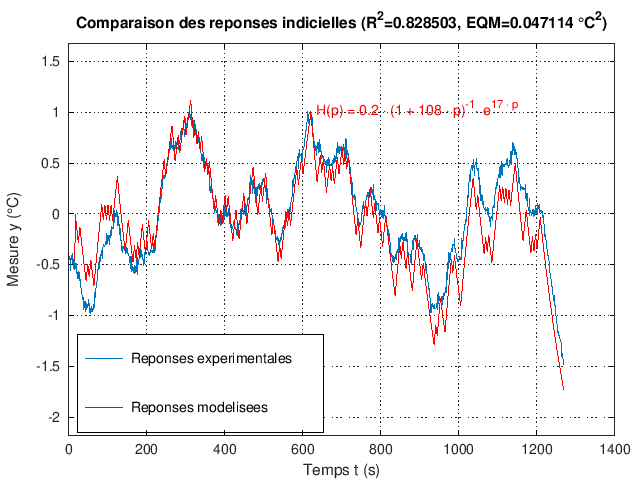

In [45]:
% Prétraitement des données
u = u - 50;
y = detrend(y);

% Calcul de la réponse indicielle du modèle en fonction de son ordre
if n==1 % Ordre un
    H = tf(K,[tau 1]);
    textmod = sprintf('H(p) = %g \\cdot (1 + %g \\cdot p)^{-1}', K, tau); % Équation à afficher
else % Ordre deux ou plus
    H = tf(K,[1/omega0^2 2/omega0 1]);
    textmod = sprintf('H(p) = %g \\cdot (1 + p / %g)^{-2}', K, omega0);  % Équation à afficher
end
ymod(find(t<taur)) = y(1); % Prise en compte du retard
if taur>0
    textmod = strcat(textmod, sprintf('\\cdot e^{%g \\cdot p}', taur));  % Équation à afficher
end
ymod = lsim(H,u,t);

 % Prise en compte du retard
m = length(find(t<taur));
ymod = [ones(m,1)*y(1); ymod(1:end-m)];

% Calcul du score
R2 = (var(y) - var(ymod-y)) / var(y)
EQM = mean((ymod-y).^2)

% Tracé des courbes
plot(t,y, t,ymod, 'r-'); grid on;
title(sprintf('Comparaison des reponses indicielles (R^2=%f, EQM=%f %s^2)', R2, EQM, yunit))
ylabel(sprintf('Mesure y (%s)',yunit))
xlabel('Temps t (s)')
legend('Reponses experimentales','Reponses modelisees', 'location', 'southwest');
set(gca, 'gridlinestyle', ':');
ylims = get(gca,'ylim'); ylims = [ylims(1)-diff(ylims)/20 ylims(2)+diff(ylims)/20]; ylim(ylims);

% Ajout des étiquettes sur le graphique
text(mean(t),max(y),textmod, 'fontsize', 14, 'color', [1 0 0]);

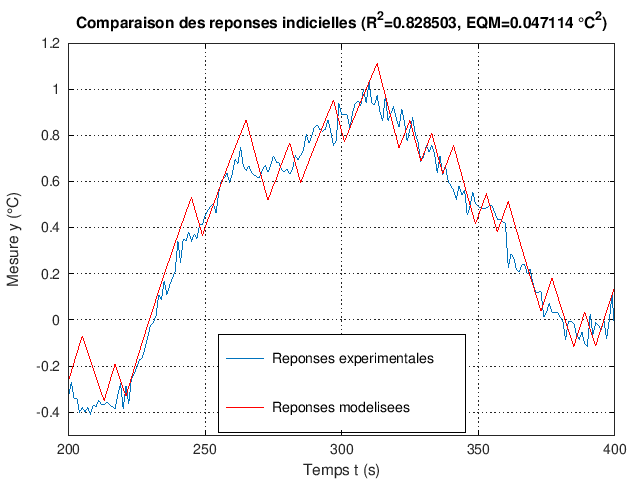

In [46]:
% Tracé des courbes
plot(t,y, t,ymod, 'r-'); grid on;
title(sprintf('Comparaison des reponses indicielles (R^2=%f, EQM=%f %s^2)', R2, EQM, yunit))
ylabel(sprintf('Mesure y (%s)',yunit))
xlabel('Temps t (s)')
legend('Reponses experimentales','Reponses modelisees', 'location', 'south');
set(gca, 'gridlinestyle', ':');
xlim([200 400]);
ylim([-0.5 1.2]);

## Conclusion n°2

> Le modèle du procédé $H(p)$, dont les paramètres ont été déterminés à partir d'une réponse indicielle expérimentale, **ne permet pas** de représenter de façon correcte d'autres types de réponses, obtenues avec des sollicitations différentes (dans ce cas un signal binaire pseudo-aléatoire). 

> Le comportement à basses fréquences (l'allure générale "lente" de la courbe) est assez bien représenté, car la réponse indicielle qui a servi à la modélisation fournit essentiellement des informations correspondant aux basses fréquences.

> Le comportement à hautes fréquences (les variations rapides superposées à l'allure générale de la courbe) est très mal représenté, car la réponse indicielle qui a servi à la modélisation fournit très peu d'informations correspondant aux hautes fréquences.

## Corrolaire

> Si l'on veut obtenir un modèle de procédé représentatif de son comportement dans différents domaines de fréquences, il faudra utiliser, pour la modélisation, des données plus "riches" en informations dans tous ces domaines (comme par exemple la réponse au pseudo-bruit-blanc). 